In [54]:
import numpy as np
import pandas as pd
from pandas.io.formats.format import DataFrameFormatter
from pandas.io.parsers import read_csv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
import math
import scipy.optimize as opt
from scipy.optimize import minimize
from sklearn.svm import SVC


In [61]:
 #Leemos el archivo csv
data=pd.read_csv("heart.csv")
#Parseamos las columnas que no tengan enteros a enteros
data.Sex=[1 if each == "M" else 0 for each in data.Sex]
data.ExerciseAngina=[1 if each == "N" else 0 for each in data.ExerciseAngina]
data.ChestPainType=[0 if each == "ASY"  else 1 if each=="NAP" else 2  for each in data.ChestPainType]
data.RestingECG=[0 if each == "Normal"  else 1 if each=="LVH" else 2  for each in data.RestingECG]
data.ST_Slope=[0 if each == "Flat"  else 1 if each=="Up" else 2  for each in data.ST_Slope]
#guardamos data
valores=data.values
#la columna Y tendra los ataques al corazon
Y=data.HeartDisease.values
#Borramos la columna para asignar a X el resto de columnas
data.drop(['HeartDisease'], axis=1,inplace=True)
X=data.values

In [62]:

def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    return s


def coste(theta, X, Y,landa):
    H = sigmoid(np.matmul(X, theta))
    thetaAux=theta[1:]
    return (-1/(len(X))) * ( np.dot(Y, np.log(H)) + np.dot(1-Y, np.log(1-H))) + (landa/2*len(X))*sum(thetaAux*thetaAux)

def gradiente(theta, X, Y,landa):
    H=sigmoid(np.matmul(X, theta))
    return (1/len(Y)) * np.matmul((X.T), H-Y) + (landa/len(X))*theta


def evalua(theta,X,Y):
    xs = sigmoid(np.matmul(X,theta))
    xspositivas = np.where(xs >= 0.5)
    xsnegativas = np.where(xs < 0.5)
    xspositivasejemplo = np.where (Y == 1 )
    xsnegativasejemplo = np.where (Y == 0 )
    #Printea los casos en los que la funcion sigmoide con las thetas de ejemplo indica que va a tener un ataque
  #  print("Acertadas en el sigmoide: ", xspositivas)
  #  print("Positivas en los ejemplos: ", xspositivasejemplo)
    porcentajepos = np.intersect1d(xspositivas,xspositivasejemplo).shape[0]/xs.shape[0]
    porcentajeneg = np.intersect1d(xsnegativas,xsnegativasejemplo).shape[0]/xs.shape[0]
   # print("Total:", porcentajeneg + porcentajepos)
    return porcentajepos + porcentajeneg



def calcula_porcentaje(X,Y,theta):
    sig = sigmoid(np.matmul(X,theta))
    ev_correct = np.sum((sig >= 0.5) == Y)
    return ev_correct/len(sig) * 100



def add_ones(valores):
    unos = np.ones((valores.shape[0], 1), dtype=valores.dtype)
    return np.hstack((unos , valores))

def RegresionLogistica():
    #Leemos el archivo csv
    data=pd.read_csv("heart.csv")
    #Parseamos las columnas que no tengan enteros a enteros
    data.Sex=[1 if each == "M" else 0 for each in data.Sex]
    data.ExerciseAngina=[1 if each == "N" else 0 for each in data.ExerciseAngina]
    data.ChestPainType=[0 if each == "ASY"  else 1 if each=="NAP" else 2  for each in data.ChestPainType]
    data.RestingECG=[0 if each == "Normal"  else 1 if each=="LVH" else 2  for each in data.RestingECG]
    data.ST_Slope=[0 if each == "Flat"  else 1 if each=="Up" else 2  for each in data.ST_Slope]
    #guardamos data
    valores=data.values
    #la columna Y tendra los ataques al corazon
    Y=data.HeartDisease.values
    #Borramos la columna para asignar a X el resto de columnas
    data.drop(['HeartDisease'], axis=1,inplace=True)
    X=data.values
    
    landa=1.0
    precision = 0.0
    NUM_PRUEBAS = 10
    for i in range(NUM_PRUEBAS):
       np.random.shuffle(X)
       #Vamos a separar los ejemplos en 80% para entrenar y un 20% para evaluar  
      # X = add_ones(X)
       X= np.hstack((  np.ones((valores.shape[0], 1), dtype=valores.dtype), valores))
       x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,shuffle = True)
       theta = np.zeros((X.shape[1],1))
       result = opt.fmin_tnc(func=coste,x0=theta ,fprime=gradiente,args =(x_train, y_train,landa))
       theta = result[0]
       
       precision += evalua(theta,x_test,y_test)
    print(format((precision / NUM_PRUEBAS)* 100, '.2f' ),"%")
    return precision/NUM_PRUEBAS *100


    
RegresionLogistica()

TypeError: object of type 'builtin_function_or_method' has no len()

In [59]:


#A1==A2
#Z2==Z3
#A2==H
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    #a1 = np.hstack([np.ones([m, 1]), X]) No añadimos porque ya lo hicimos antes
    z2 = np.dot(X, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)

    return X, z2, a2, z3, h
def random_thetas(l_in, l_out, range=0.12):
    W = np.zeros((l_out, 1 + l_in))
    W = np.random.rand(l_out, 1 + l_in) * (2 * range) - range
    return W


def unroll_thetas(params, n_entries, n_hidden, n_et):
    theta1 = np.reshape(params[:n_hidden * (n_entries + 1)], (n_hidden, (n_entries + 1)))
    theta2 = np.reshape(params[n_hidden * (n_entries + 1):], (n_et, (n_hidden + 1)))

    return theta1, theta2


def CosteFun(params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, reg):
    theta1,theta2 = unroll_thetas(params_rn, num_entradas, num_ocultas, num_etiquetas)
    a1,z2,a2,z3,h = forward_propagate(X,theta1,theta2)
    J = 0
    for i in range(len(X)):
        J += (-1/(len(X)))*(np.dot(Y[i],np.log(h[i]))+np.dot((1-Y[i]),np.log(1-h[i])))
    J += (reg/ (2*len(X))) * ( ( np.sum(np.square(theta1[:,1:]))) + (np.sum(np.square(theta2[:,1:]))) )
    return J


def getYMatrix(Y, nEtiquetas):
    nY = np.zeros((len(Y), nEtiquetas))
    yaux = np.array(Y) -1
    
    for i in range(len(nY)):
        z = yaux[i]
        if(isinstance(z, np.uint8)):
            if(z == 10): z = 0
            nY[i][z] = 1
        else:
            z = yaux[i].all()
            if(z == 10): z = 0
            nY[i][z] = 1
            
    return nY

def sigmoideDerivada(value):
    temp = sigmoid(value)
    return temp * (1 - temp)
    
def backprop(params_rn,num_entradas,num_ocultas,num_etiquetas,X,y, reg):
    #Luego "deserializamos" los parametros
    m = X.shape[0]
    X = add_ones(X)
    theta1,theta2 = unroll_thetas(params_rn, num_entradas, num_ocultas, num_etiquetas)
    a1,z2,a2,z3,h = forward_propagate(X,theta1,theta2)
    cost = CosteFun(params_rn,num_entradas, num_ocultas, num_etiquetas, X, y, reg)
    #Claculo de deltas
    delta1 = 0
    delta2 = 0
    for t in range(m):
        a1t = a1[t, :] # (1, 401)
        a2t = a2[t, :] # (1, 26)
        ht = h[t, :] # (1, 10)
        yt = y[t] # (1, 10)
        d3t = ht - yt # (1, 10)
        d2t = np.dot(theta2.T, d3t) * (a2t * (1 - a2t)) # (1, 26)
        delta1 = delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        delta2 = delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])
    delta1 = delta1/m
    delta2 = delta2/m
    #Gradiente de cada delta
    delta1[:,1:] = delta1[:,1:] + (reg *theta1[:,1:]) / m
    delta2[:,1:] = delta2[:,1:] + (reg *theta2[:,1:]) / m
    #Juntamos los gradientes
    gradiente = np.concatenate((np.ravel(delta1),np.ravel(delta2)))
    return cost, gradiente



def add_ones(valores):
    unos = np.ones((valores.shape[0], 1), dtype=valores.dtype)
    return np.hstack((unos , valores))

def RedesNeuronales():
    #Leemos el archivo csv
    data=pd.read_csv("heart.csv")
    #Parseamos las columnas que no tengan enteros a enteros
    data.Sex=[1 if each == "M" else 0 for each in data.Sex]
    data.ExerciseAngina=[1 if each == "N" else 0 for each in data.ExerciseAngina]
    data.ChestPainType=[0 if each == "ASY"  else 1 if each=="NAP" else 2  for each in data.ChestPainType]
    data.RestingECG=[0 if each == "Normal"  else 1 if each=="LVH" else 2  for each in data.RestingECG]
    data.ST_Slope=[0 if each == "Flat"  else 1 if each=="Up" else 2  for each in data.ST_Slope]
    #guardamos data
    valores=data.values
    #la columna Y tendra los ataques al corazon
    Y=data.HeartDisease.values
    #Borramos la columna para asignar a X el resto de columnas
    data.drop(['HeartDisease'], axis=1,inplace=True)
    X=data.values
    ######
    num_entradas = 11
    #Las unidades de la capa oculta
    num_ocultas = 40
    #Las etiquetas de la salida
    num_etiquetas = 2
    #Y.reshape(Y.shape[0],1)
    m = X.shape[0]
    y_onehot = np.zeros((m,num_etiquetas))
    for i in range(m):
        y_onehot[i][int(Y[i])]= 1
       
    #Sacamos las matrices de thetas 
    thetas1 = random_thetas(num_entradas,num_ocultas)
    thetas2 = random_thetas(num_ocultas,num_etiquetas)
    Thetas = [thetas1,thetas2]
    #Unrolleamos los parametros y los juntamos en el mismo
    unrolled_Thetas = [Thetas[i].ravel() for i,_ in enumerate(Thetas)]
    nn_params = np.concatenate(unrolled_Thetas)
   #print("Shape of Theta1: ", thetas1.shape)
   #print("Shape of Theta2: ", thetas2.shape)
   #print("Shape of nn_params: ", nn_params.shape)
    #EVALUACION
    #Buscamos mediante scipy las thetas optimas
    result = minimize(fun=backprop, x0=np.append(thetas1,thetas2), args=(num_entradas, num_ocultas,
    num_etiquetas, X, y_onehot,1000 ), method = 'TNC', jac = True, options = {'maxiter': 500, 'disp':True})
    theta1,theta2 = unroll_thetas(result.x,num_entradas,num_ocultas,num_etiquetas)
    #Creamos la NN con las thetas optimizadas
    X= add_ones(X)
    h = forward_propagate(X,theta1, theta2)[3]
  #print(h[0])
  #print(len(h))
  #print(len(X))
    correct = 0
    wrong = 0
    falsePositive = 0
    falseNegative = 0
    #Y comparamos la respuesta de la NN con la real
    for i in range(len(X)):
        maxIndex = np.argmax(h[i])
        if(maxIndex == Y[i]):
            correct += 1
        else:
            wrong += 1
            if(Y[i] == 1):
                falseNegative +=1
            else:
                falsePositive += 1
       
   # print()
   # print("Hit: ", correct)
   # print("Miss: ", wrong)
   # print("False Positives: ", falsePositive)
   # print("False Negatives: ", falseNegative)
   # print("Accuracy: ",format((correct / (correct+wrong))*100, '.2f' ),"%")
    print(format(correct / (correct+wrong) * 100, '.2f' ),"%")
    return correct / (correct+wrong) * 100
 

    
RedesNeuronales()

55.34 %


55.33769063180828

In [60]:

def SVM():
    #Leemos el archivo csv
    data=pd.read_csv("heart.csv")
    #Parseamos las columnas que no tengan enteros a enteros
    data.Sex=[1 if each == "M" else 0 for each in data.Sex]
    data.ExerciseAngina=[1 if each == "N" else 0 for each in data.ExerciseAngina]
    data.ChestPainType=[0 if each == "ASY"  else 1 if each=="NAP" else 2  for each in data.ChestPainType]
    data.RestingECG=[0 if each == "Normal"  else 1 if each=="LVH" else 2  for each in data.RestingECG]
    data.ST_Slope=[0 if each == "Flat"  else 1 if each=="Up" else 2  for each in data.ST_Slope]
    #guardamos data
    valores=data.values
    #la columna Y tendra los ataques al corazon
    Y=data.HeartDisease.values
    #Borramos la columna para asignar a X el resto de columnas
    data.drop(['HeartDisease'], axis=1,inplace=True)
    X=data.values

    precision=0
    numIter = 1
    #Parametro de regulalizacion
    C_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    #copiamos sigma
    sigma_vec = np.copy(C_vec)

    #for con iteraciones  para probar
    for x in range(0, numIter):
        #variables para guardar los mejores parametros
        bestC = 0.01
        bestSigma = 0.01
        bestScore = -1
        #Vamos a separar los ejemplos en 80% para entrenar y un 20% para evaluar
        X_new, Xval, y_new, Yval = train_test_split(X, Y, test_size = 0.20,shuffle = True)
        #recorremos el vector de seleccion de C y sigma quedandonos con los mejores parametros (C,Sigma,Score)
        for c in  C_vec:
            for sigma in sigma_vec:
                auxKernel = SVC(C = c, kernel = 'rbf', gamma =  1/(2*sigma **2))
                auxKernel.fit(X_new, y_new.flatten())
                score = auxKernel.score(Xval,Yval)
                if (score > bestScore):
                    bestC = c
                    bestSigma = sigma   
                    bestScore = score
        #Calculo del SVM
        svm = SVC(kernel = 'rbf', C = bestC, gamma = 1 / (2 * bestSigma **2))
        #Modelos el svm con X, y en nuestro caso son el 80% de la muestra
        svm.fit(X_new, y_new.flatten())
        #Calculamos la precision del SVM para un conjunto de prueba, el 20% de la muestra en nuestro caso
        precision += test(svm, Xval, Yval)
    #imprimimos la media de precicion del numero de iteraciones
    print(format((precision / numIter)* 100, '.2f' ),"%")
    return precision / numIter * 100
       
    

def test(svm, X, Y):
    prediction = svm.predict(X)
    accuracy = np.mean((prediction == Y).astype(int))
    return accuracy

SVM()

52.72 %


52.71739130434783

In [ ]:
print("Precision Regresion Logistica")
log=RegresionLogistica()
print("Precision Redes Neuronales")
red=RedesNeuronales()
print("Precision SVM")
sv=SVM()



Precision Regresion Logistica
72.55 %
Precision Redes Neuronales


<ipython-input-29-3644af4a66f7>:2: RuntimeWarning: overflow encountered in exp
  s = 1.0 / (1.0 + np.exp(-x))


66.34 %
Precision SVM
81.52 %
81.52173913043478


81.52173913043478


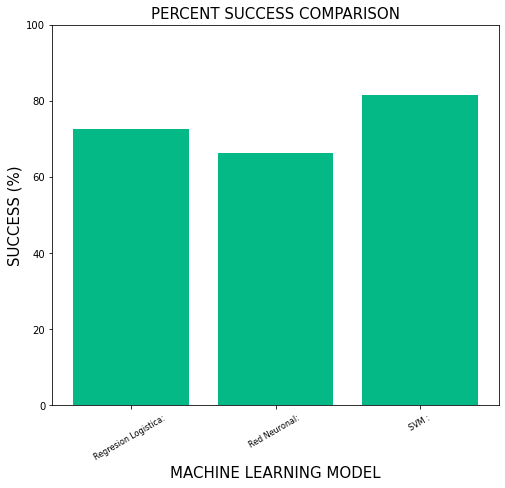

In [ ]:

xBars = ['Regresion Logistica: ', 
         'Red Neuronal: ', 
         'SVM : ']   
ancho = 0.8
fig, ax = plt.subplots(figsize=(8,7))
index = np.arange(len(xBars))
print(sv)
plt.bar(index, [float(log),float(red),float(sv)], ancho, color='#04B986')
plt.xlabel('MACHINE LEARNING MODEL', fontsize=15)
plt.ylabel('SUCCESS (%)', fontsize=15)
plt.xticks(index, xBars, fontsize=8, rotation=30)
plt.title('PERCENT SUCCESS COMPARISON', fontsize=15)
plt.ylim((0, 100))
plt.savefig('ComparaciondeEficiencia.png')